In [1]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from closed_circuit import *
from p_tqdm import p_map

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dydt(t,y, params):
    C_p, Za_p, R_p = params
    cap_p = PressureSystem(C_p, Za_p, R_p)
    
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy

In [3]:
def ODE(params):
    C_p, Za_p, R_p = params
    cap_p = PressureSystem(C_p, Za_p, R_p)
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA', args = [params])
    sol.t = sol.t[int(T*1000):int(T*1100)]
    v_lv = sol.y[0][int(T*1000):int(T*1100)]
    v_la = sol.y[1][int(T*1000):int(T*1100)]
    q_av = sol.y[2][int(T*1000):int(T*1100)]
    q_mv = sol.y[3][int(T*1000):int(T*1100)]
    xi_av = sol.y[4][int(T*1000):int(T*1100)]
    xi_mv = sol.y[5][int(T*1000):int(T*1100)]
    pa = sol.y[6][int(T*1000):int(T*1100)]
    v_rv = sol.y[7][int(T*1000):int(T*1100)]
    v_ra = sol.y[8][int(T*1000):int(T*1100)]
    q_tv = sol.y[9][int(T*1000):int(T*1100)]
    q_pv = sol.y[10][int(T*1000):int(T*1100)]
    xi_tv = sol.y[11][int(T*1000):int(T*1100)]
    xi_pv = sol.y[12][int(T*1000):int(T*1100)]
    pb = sol.y[13][int(T*1000):int(T*1100)]
    
    p_lv, p_rv, p_la, p_ra, p_ao, p_pa = [], [], [], [], [], []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_lv.append(lv.p(v_lv[j], i))
        p_la.append(la.p(v_la[j], i))
        p_ra.append(ra.p(v_ra[j], i))
        p_rv.append(rv.p(v_rv[j], i))
        p_ao.append(cap_s.pi(q_av[j], pa[j]))
        p_pa.append(cap_p.pi(q_pv[j], pb[j]))
    p_lv, p_rv, p_ao, p_pa, p_la, p_ra= np.array(p_lv)/1333, np.array(p_rv)/1333, np.array(p_ao)/1333, np.array(p_pa)/1333, np.array(p_la)/1333, np.array(p_ra)/1333
    return p_lv, p_rv, p_ao, p_pa, p_la, p_ra, v_lv, v_la, v_rv, v_ra, q_av, q_mv, q_tv, q_pv, xi_av, xi_mv, xi_tv, xi_pv

In [4]:
def data_processing(v_lv, v_rv, p_lv, p_rv, p_ao):
    max_volume_rv = max(v_rv)
    min_volume_rv = min(v_rv)
    sv_rv = max_volume_rv - min_volume_rv
    rvef = sv_rv / max_volume_rv
    max_volume_lv = max(v_lv)
    
    min_volume_lv = min(v_lv)
    sv_lv = max_volume_lv - min_volume_lv
    lvef = sv_lv / max_volume_lv
    return sv_rv, sv_lv, rvef, lvef

In [5]:
def err_cal(params):
    err = []
    for i in range(len(params)):
        diff = (params[i] - params[0])/params[0]
        err.append(diff*100)
    err = np.array(err)
    return err

In [283]:
def bar_fig(ax, model, *args):
    positions = []
    labels = [str(i) for i in range(len(model))]
    colors = [original] * len(model)
    color_backup = [L1,L2, L3, L4, L5, L6]    
    for i, value in enumerate(args):
        if model[1] > model[0]:
            insert_position = np.searchsorted(model, value)
        else:
            insert_position = np.searchsorted(model[::-1], value, side='right')
            insert_position = len(model) - insert_position
        
        labels = np.insert(labels, insert_position, f'C{i+1}')
        model = np.insert(model, insert_position, value)
        colors = np.insert(colors, insert_position, color_backup[i])
        positions.append(insert_position)
    ip = int(np.mean(positions))
    start_index = max(0, ip - 5)
    end_index = min(len(model), ip + 7)
    
    model = model[start_index:end_index]
    labels = labels[start_index:end_index]
    colors = colors[start_index:end_index]

    ax.bar(labels, model, color=colors)

In [213]:
T = 0.8
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 3, Emin = 0.08, V0 = 10,T = T, deltat = 0.01)# V0 (mL), T (s)
la=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.17, Emin = 0.08,V0 = 3,T = T, deltat = 0.01, delay = 0.85*T) # V0 (mL), T (s)
rv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 0.8, Emin = 0.04, V0 = 10, T = T, deltat = 0.01) # Ks, V0 ,T
ra=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.15, Emin = 0.04, V0 = 3, T = T, deltat = 0.01, delay = 0.85*T) # Ks, V0, T
av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, Kvo = 0.12,Kvc = 0.15, p_oc = 0)
mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, Kvo = 0.3,Kvc = 0.4, p_oc = 0)
tv=ValveinP(1.06,2,6, 0.3,0.4, 0) #poc (mmHg)
pv=ValveinP(1.06,1.9,2.8, 0.2,0.2, 0) #poc

data = np.array([
 0.00061      , 103.44867    , 1471.26289  , 0.00272      , 26.64387     , 165.27640 
])
C_s, Za_s, R_s, C_p, Za_p, R_p = data[0], data[1], data[2], data[3], data[4], data[5]
cap_s=PressureSystem(C_s, Za_s, R_s)
cap_p=PressureSystem(C_p, Za_p, R_p)
t_end=10
t = [0,t_end]
t_step = 0.01
t_span=np.arange(0,t_end,t_step)
index_range = slice(int(1000*T), int(1100*T))

In [214]:
input_para = [[0.00272, 26.64387, 165.27640 ]]
labels = [' Healthy']
rm = [0]
for n in np.arange(1,18,1):
    pul_cir = lumped_resection_unified(C = cap_p.C, Za = cap_p.Za, R = cap_p.R, n = n, N =19)
    R = pul_cir.updated_R()
    Za = pul_cir.updated_Za()
    C = pul_cir.updated_C()
    input_para.append([C, Za, R])
    labels.append('{} Seg(s) Res. '.format(n))
    rm.append(n)
input_para = np.array(input_para)

In [215]:
results = np.array(p_map(ODE, input_para, num_cpus = 32))
p_lv = results[:, 0]
p_rv = results[:, 1]
p_pa = results[:, 3]
v_rv = results[:, 8]
v_lv = results[:, 6]
p_ao = results[:, 2]
results = np.array(p_map(data_processing, v_lv, v_rv, p_lv, p_rv, p_ao, num_cpus = 32))
sv_rv, sv_lv, rvef, lvef = results[:, 0], results[:, 1], results[:, 2], results[:, 3]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 744.10it/s]


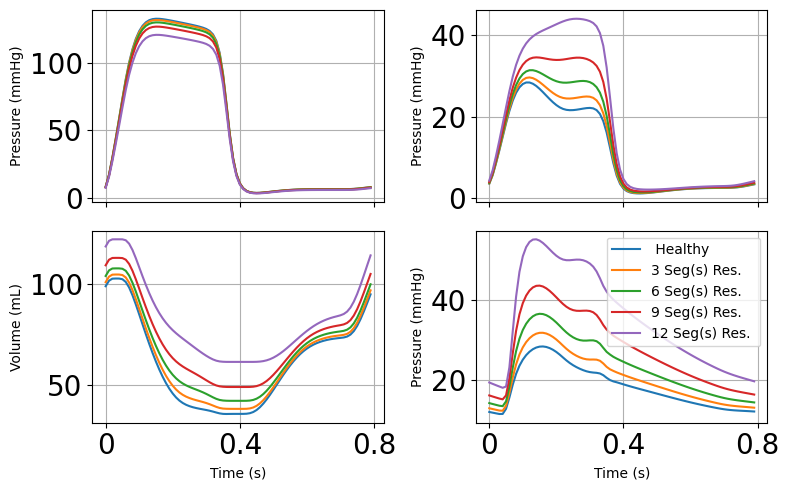

In [216]:
t = np.arange(0,0.8,0.01)
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True)
custom_ticks = [0, 0.4, 0.8]  # 自定义刻度位置
# 第一张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[0,0].plot(t, p_lv[i], label=labels[j])
axs[0,0].set_ylabel('Pressure (mmHg)')
axs[0,0].grid(True)
axs[0,0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].set_xticks(custom_ticks)
axs[1,0].set_xlabel('Time (s)')
axs[0, 0].set_xticklabels(custom_ticks, fontsize=15)
# 第二张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[0,1].plot(t, p_rv[i], label=labels[j])
axs[0,1].set_ylabel('Pressure (mmHg)')
axs[0,1].grid(True)
axs[0,1].tick_params(axis='both', which='major', labelsize=20)
# 第三张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[1,0].plot(t, v_rv[i], label=labels[j])
axs[1,0].set_ylabel('Volume (mL)')
axs[1,0].grid(True)
axs[1,0].tick_params(axis='both', which='major', labelsize=20)
# 第四张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[1,1].plot(t, p_pa[i], label=labels[j])
axs[1,1].set_ylabel('Pressure (mmHg)')
axs[1,1].set_xlabel('Time (s)')
axs[1,1].legend()
axs[1,1].grid(True)
axs[1,1].tick_params(axis='both', which='major', labelsize=20)
# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig('shared_x_axis_plots.svg')
plt.show()

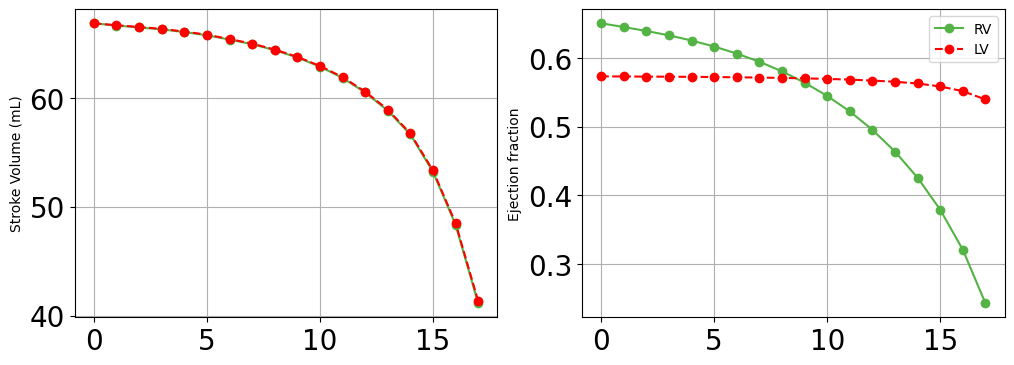

In [11]:
t = np.arange(0,0.8,0.01)
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
custom_ticks = [0, 5, 10,15]  # 自定义刻度位置
# 第一张图
axs[0].plot(rm, sv_rv, marker='o', linestyle='-', color='#54B345', label = 'RV')
axs[0].plot(rm, sv_lv, marker='o', linestyle='--', color='r', label = 'LV')
axs[0].set_ylabel('Stroke Volume (mL)')
axs[0].grid(True)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_xticks(custom_ticks)
axs[0].set_xticklabels(custom_ticks, fontsize=20)
# 第二张图

axs[1].plot(rm, rvef, marker='o', linestyle='-', color='#54B345', label='RV')
axs[1].plot(rm, lvef, marker='o', linestyle='--', color='r', label='LV')
axs[1].set_ylabel('Ejection fraction')
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_xticks(custom_ticks)
axs[1].grid(True)
plt.legend()
#plt.savefig('cardiac_function.svg')
plt.show()

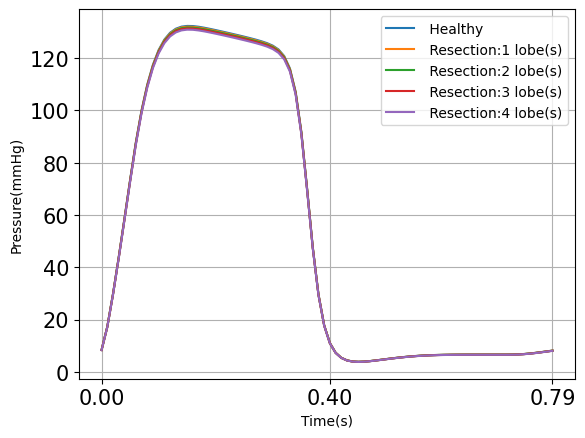

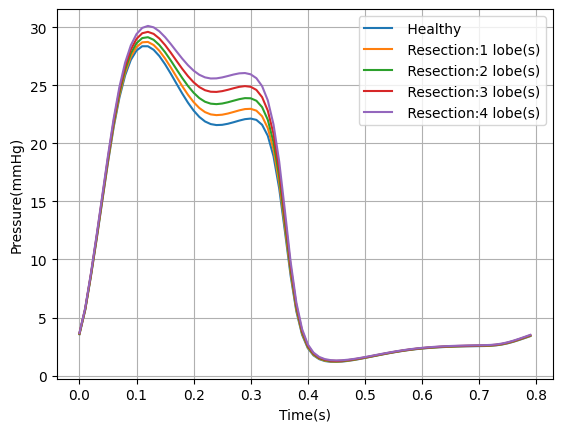

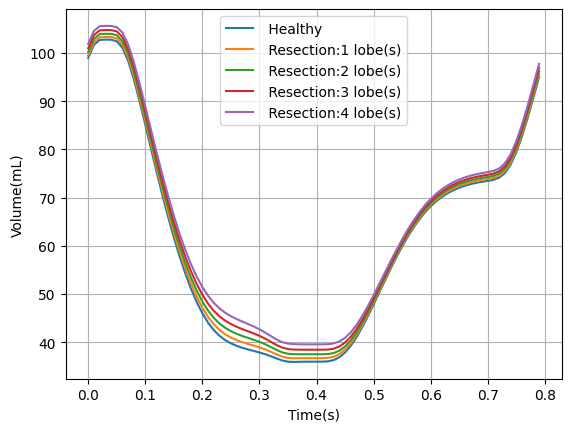

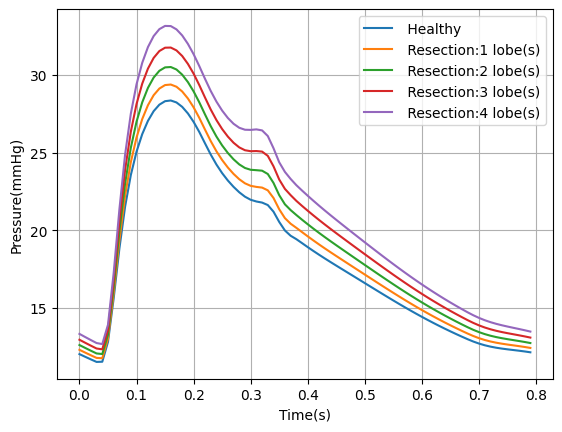

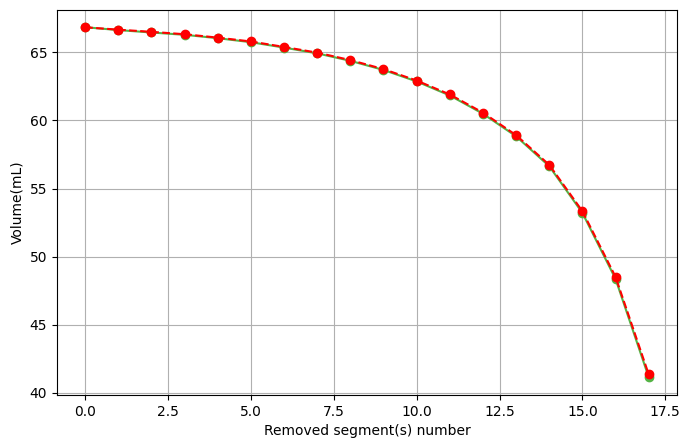

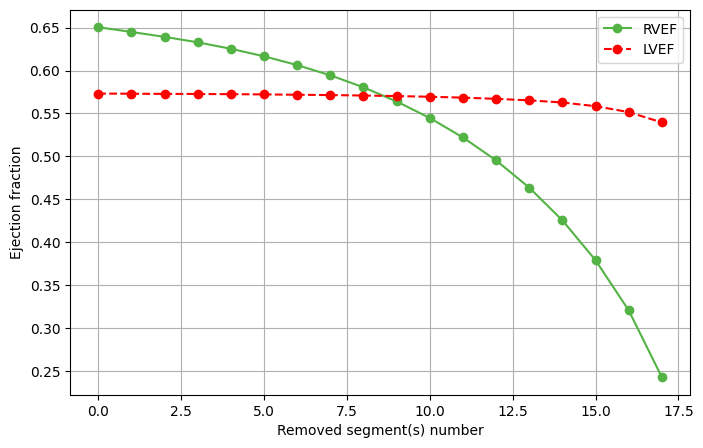

In [12]:
t = np.arange(0,0.8,0.01)
for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, p_lv[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Pressure(mmHg)')
plt.xlabel('Time(s)')
plt.xticks(ticks=[t[0], t[len(t)//2], t[-1]], fontsize=15)  # 仅显示3个刻度
plt.yticks(fontsize=15)
plt.savefig('p_lv.svg')
plt.show()

for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, p_rv[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Pressure(mmHg)')
plt.xlabel('Time(s)')
plt.savefig('p_rv.svg')
plt.show()

for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, v_rv[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Volume(mL)')
plt.xlabel('Time(s)')
plt.savefig('v_rv.svg')
plt.show()

for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, p_pa[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Pressure(mmHg)')
plt.xlabel('Time(s)')
plt.savefig('p_pa.svg')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(rm, sv_rv, marker='o', linestyle='-', color='#54B345', label = 'SVRV')
plt.plot(rm, sv_lv, marker='o', linestyle='--', color='r', label = 'SVLV')
plt.xlabel("Removed segment(s) number")
plt.ylabel("Volume(mL)")
plt.grid(True)
plt.savefig('sv.svg')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(rm, rvef, marker='o', linestyle='-', color='#54B345', label='RVEF')
plt.plot(rm, lvef, marker='o', linestyle='--', color='r', label='LVEF')
plt.xlabel("Removed segment(s) number")
plt.ylabel("Ejection fraction")
plt.legend()
plt.grid(True)
plt.savefig('ef.svg')
plt.show()

In [13]:
rvedv = []
rvesv = []
lvedv = []
lvesv = []
paps = []
papd = []
rvsp = []
for i in range(len(v_rv)):
    rvedv.append(max(v_rv[i]))
    rvesv.append(min(v_rv[i]))
    lvedv.append(max(v_lv[i]))
    lvesv.append(min(v_lv[i]))
    paps.append(max(p_pa[i]))
    papd.append(min(p_pa[i]))
    rvsp.append(max(p_rv[i]))
rvedv = np.array(rvedv)
rvesv = np.array(rvesv)
lvedv = np.array(lvedv)
lvesv = np.array(lvesv)
paps = np.array(paps)
papd = np.array(papd)
rvsp = np.array(rvsp)

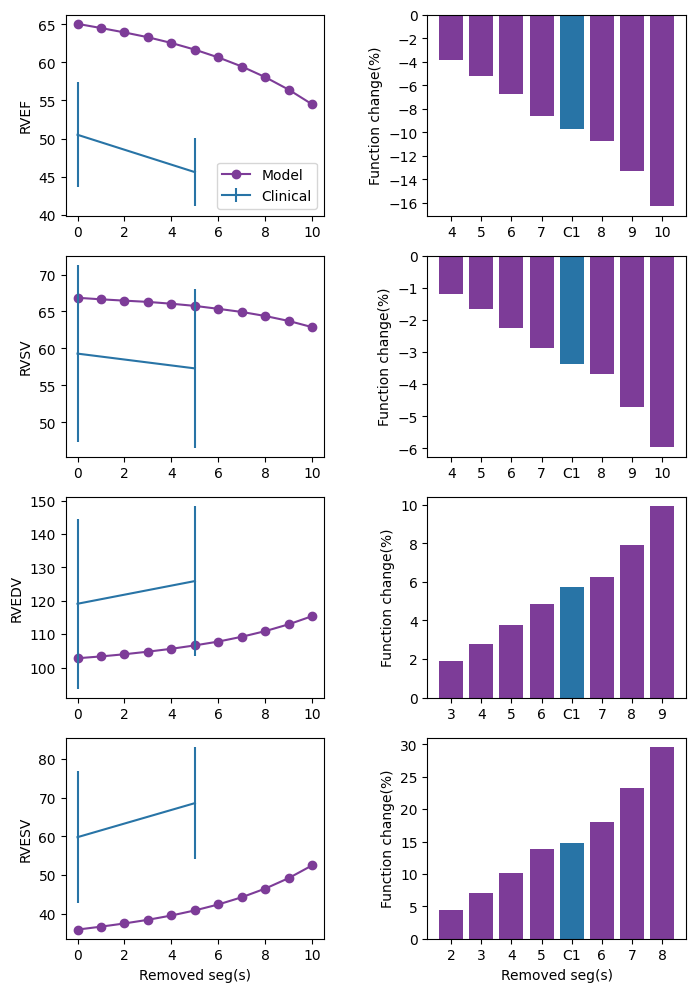

In [175]:
original = '#7d3c98'
L1 = '#2874a6'
L2 = '#d4ac0d'
L3 = '#cb4335'
L4 = '#469990'
L5 = '#fabebe'
L6 = '#af601a'
L7 = '#5d6d7e'
status = np.array(['Pre-op', 'Post-op'])
rvef_cl = np.array([50.5, 45.6])
rvef_err = np.array([6.9, 4.5])
fig, axs = plt.subplots(4, 2, figsize=(8, 12)) 
axs[0,0].plot(rm[0:11], rvef[0:11]*100, marker='o', linestyle='-', color=original, label='Model')
axs[0,0].set_ylabel('RVEF')
axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[0,0].errorbar([0,5], rvef_cl, yerr = rvef_err ,color=L1, label = 'Clinical')
axs[0,0].legend()
err_rvef = err_cal(rvef)
rvef_st = [50.5, 45.6]
err_rvefst = err_cal(rvef_st)
bar_fig(axs[0, 1], err_rvef, err_rvefst[-1])
axs[0,1].yaxis.set_major_locator(MaxNLocator(integer=True))

#rvedv_cl = [119.1, 125.9]
#rvedv_err = [25.4,22.5]

svrv_cl = [59.3, 57.3]
svrv_err = [12,10.7]

axs[1,0].plot(rm[0:11], sv_rv[0:11], marker='o', linestyle='-', color=original, label='Model')
axs[1,0].set_ylabel('RVSV')
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))


axs[1,0].errorbar([0, 5], svrv_cl, yerr = svrv_err ,color=L1, label = 'Clinical')

err_svrv = err_cal(sv_rv)
err_svrvst = err_cal(svrv_cl)
bar_fig(axs[1,1], err_svrv, err_svrvst[-1])


rvedv_cl = [119.1, 125.9]
rvedv_err = [25.4, 22.5]

axs[2,0].plot(rm[0:11], rvedv[0:11], marker='o', linestyle='-', color=original, label='Model')
axs[2,0].set_ylabel('RVEDV')
axs[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[2,0].errorbar([0,5], rvedv_cl, yerr = rvedv_err ,color=L1, label = 'Clinical')
err_rvedv = err_cal(rvedv)
err_rvedvst = err_cal(rvedv_cl)
bar_fig(axs[2,1], err_rvedv, err_rvedvst[-1])

rvesv_cl = [59.8, 68.6]
rvesv_err = [17.1, 14.5]

axs[3,0].plot(rm[0:11], rvesv[0:11], marker='o', linestyle='-', color=original, label='Model')
axs[3,0].set_ylabel('RVESV')
axs[3,0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[3,0].errorbar([0,5], rvesv_cl, yerr = rvesv_err ,color=L1, label = 'Clinical')
#ax_inset.set_ylim(80,170)

err_rvesv = err_cal(rvesv)
err_rvesvst = err_cal(rvesv_cl)
bar_fig(axs[3,1], err_rvesv, err_rvesvst[-1])
axs[3,0].set_xlabel('Removed seg(s)')
axs[3,1].set_xlabel('Removed seg(s)')
axs[1,1].set_ylabel('Function change(%)')
axs[2,1].set_ylabel('Function change(%)')
axs[3,1].set_ylabel('Function change(%)')
axs[0,1].set_ylabel('Function change(%)')
plt.subplots_adjust(wspace=0.4)
plt.savefig('RV_compare.svg', format='svg')
plt.show()

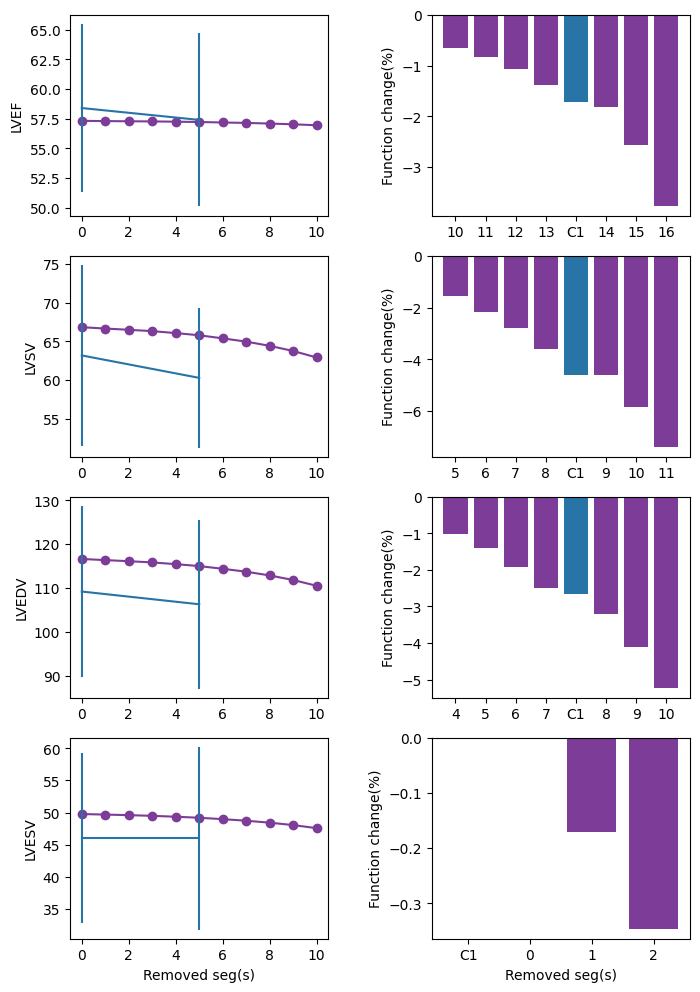

In [176]:
status = np.array(['Pre-op', 'Post-op'])
lvef_cl = np.array([58.4, 57.4])
lvef_err = np.array([7.1, 7.3])
fig, axs = plt.subplots(4, 2, figsize=(8, 12)) 
axs[0,0].plot(rm[0:11], lvef[0:11]*100, marker='o', linestyle='-', color=original, label='LVEF')
axs[0,0].set_ylabel('LVEF')
axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0,0].errorbar([0,5], lvef_cl, yerr = lvef_err ,color=L1)

err_lvef = err_cal(lvef)
err_lvefst = err_cal(lvef_cl)
bar_fig(axs[0, 1], err_lvef, err_lvefst[-1])
axs[0,1].yaxis.set_major_locator(MaxNLocator(integer=True))

#rvedv_cl = [119.1, 125.9]
#rvedv_err = [25.4,22.5]

svlv_cl = [63.2, 60.3]
svlv_err = [11.7,9]

axs[1,0].plot(rm[0:11], sv_lv[0:11], marker='o', linestyle='-', color=original, label='LVSV')
axs[1,0].set_ylabel('LVSV')
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,0].errorbar([0,5], svlv_cl, yerr = svlv_err ,color=L1)

err_svlv = err_cal(sv_lv)
err_svlvst = err_cal(svlv_cl)
bar_fig(axs[1,1], err_svlv, err_svlvst[-1])


lvedv_cl = [109.2, 106.3]
lvedv_err = [19.5, 19.2]

axs[2,0].plot(rm[0:11], lvedv[0:11], marker='o', linestyle='-', color=original, label='LVEDV')
axs[2,0].set_ylabel('LVEDV')
axs[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[2,0].errorbar([0,5], lvedv_cl, yerr = lvedv_err ,color=L1)
err_lvedv = err_cal(lvedv)
err_lvedvst = err_cal(lvedv_cl)
bar_fig(axs[2,1], err_lvedv, err_lvedvst[-1])

lvesv_cl = [46, 46]
lvesv_err = [13.2, 14.2]

axs[3,0].plot(rm[0:11], lvesv[0:11], marker='o', linestyle='-', color=original, label='LVESV')
axs[3,0].set_ylabel('LVESV')
axs[3,0].errorbar([0,5], lvesv_cl, yerr = lvesv_err ,color=L1)

err_lvesv = err_cal(lvesv)
err_lvesvst = err_cal(lvesv_cl)
bar_fig(axs[3,1], err_lvesv, err_lvesvst[-1])

axs[3,0].set_xlabel('Removed seg(s)')
axs[3,1].set_xlabel('Removed seg(s)')
axs[1,1].set_ylabel('Function change(%)')
axs[2,1].set_ylabel('Function change(%)')
axs[3,1].set_ylabel('Function change(%)')
axs[0,1].set_ylabel('Function change(%)')
plt.subplots_adjust(wspace=0.4)
plt.savefig('LV_compare.svg', format='svg')
plt.show()

## Elrakhawy 2018

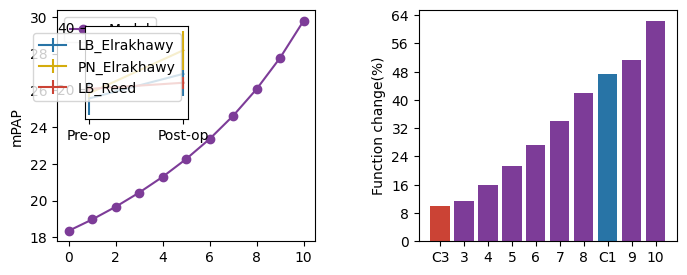

In [241]:
mpap = np.mean(p_pa, axis = 1)
mpap_elr_lb = [16.9, 24.9]
mpap_err_elr_lb = [5.3, 7.3]
mpap_elr_pn = [18.6, 32.6]
mpap_err_elr_pn = [2.2, 6.4]
fig, axs = plt.subplots(1, 2, figsize=(8, 3)) 
axs[0].plot(rm[0:11], mpap[0:11], marker='o', linestyle='-', color=original, label= 'Model')
axs[0].set_ylabel('mPAP')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[0].transAxes) 
ax_inset.errorbar(status, mpap_elr_lb, yerr = mpap_err_elr_lb ,color = L1, label = 'LB_Elrakhawy')
ax_inset.errorbar(status, mpap_elr_pn, yerr = mpap_err_elr_pn, color = L2, label = 'PN_Elrakhawy')
mpap_reed_lb = [20, 22]
mpap_err_reed_lb = [1, 2]
ax_inset.errorbar(status, mpap_reed_lb, yerr = mpap_err_reed_lb ,color = L3, label = 'LB_Reed')
axs[0].legend()
err_mpap = err_cal(mpap)
err_mpap_elr_lb = err_cal(mpap_elr_lb)
err_mpap_elr_pn = err_cal(mpap_elr_pn)
err_mpap_reed_lb = err_cal(mpap_reed_lb)
#bar_fig(axs[0, 1], err_mpap, err_mpapst_lb[-1])
bar_fig(axs[1], err_mpap, err_mpap_elr_lb[-1], err_mpap_elr_pn[-1], err_mpap_reed_lb[-1])#L1: lobe, L2: Pn, L3:LB
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()
plt.subplots_adjust(wspace=0.4)
axs[1].set_ylabel('Function change(%)')
plt.savefig('mpap.svg', format='svg')
plt.show()

## PA

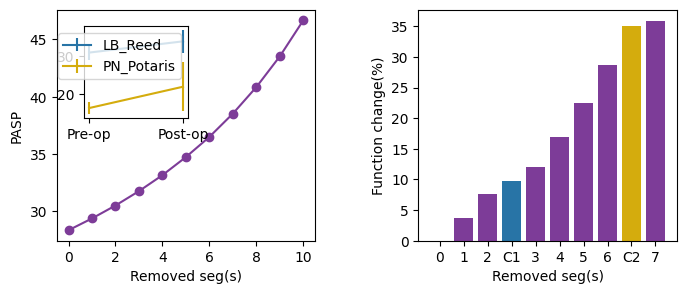

In [243]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3)) 

pap_reed_s = [31, 34]
pap_reed_s_err = [2,3]

axs[0].plot(rm[0:11], paps[0:11], marker='o', linestyle='-', color=original, label='PASP')
axs[0].set_ylabel('PASP')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[0].transAxes) 
ax_inset.errorbar(status, pap_reed_s, yerr = pap_reed_s_err ,color = L1, label = 'LB_Reed')
pap_potar_s = [16.22, 21.91]
pap_potar_err = [1.6, 6.6]
ax_inset.errorbar(status, pap_potar_s, pap_potar_err, color = L2, label = 'PN_Potaris')
ax_inset.legend()
err_pasp = err_cal(paps)
err_pasp_reed_lb = err_cal(pap_reed_s)
err_pasp_potaris_pn = err_cal(pap_potar_s)
bar_fig(axs[1], err_pasp, err_pasp_reed_lb[-1], err_pasp_potaris_pn[-1])
plt.subplots_adjust(wspace=0.4)
axs[0].set_ylabel('PASP')
axs[1].set_ylabel('Function change(%)')
axs[0].set_xlabel('Removed seg(s)')
axs[1].set_xlabel('Removed seg(s)')
plt.savefig('pasp.svg', format='svg')
plt.show()

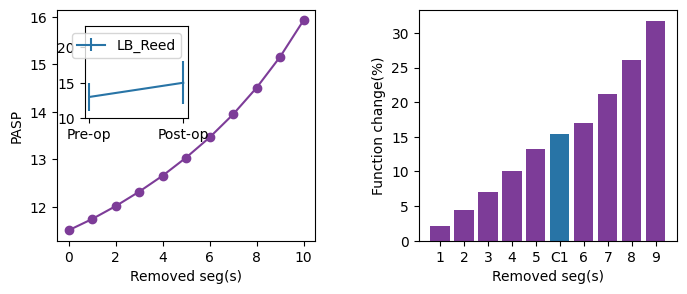

In [245]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3)) 
pap_reed_d = [13, 15]
pap_reed_d_err = [1,1]

axs[0].plot(rm[0:11], papd[0:11], marker='o', linestyle='-', color=original)
axs[0].set_ylabel('PADP')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[0].transAxes) 
ax_inset.errorbar(status, pap_reed_d, yerr = pap_reed_s_err ,color = L1, label = 'LB_Reed')
ax_inset.set_ylim(10,23)
err_padp = err_cal(papd)
err_padpst_lb = err_cal(pap_reed_d)
bar_fig(axs[1], err_padp, err_padpst_lb[-1])
#mean: 5.46667
plt.subplots_adjust(wspace=0.4)
ax_inset.legend()
axs[0].set_ylabel('PASP')
axs[1].set_ylabel('Function change(%)')
axs[0].set_xlabel('Removed seg(s)')
axs[1].set_xlabel('Removed seg(s)')
plt.savefig('PADP.svg', format='svg')
plt.show()

## RVSP

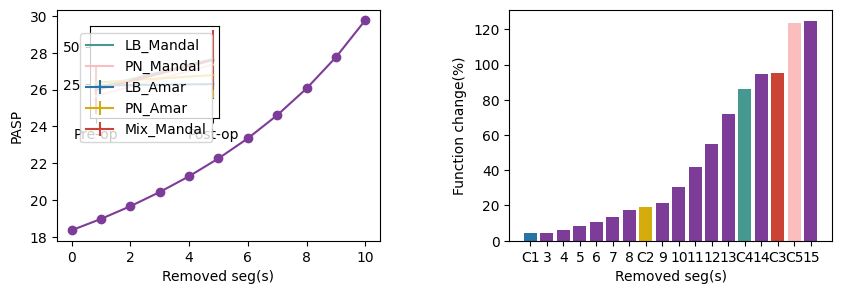

In [259]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 

rvsp_amar_lb = [24, 25]
rvsp_err_amar_lb = [6, 10]
rvsp_amar_pn = [26, 31]
rvsp_err_amar_pn = [11, 15]
rvsp_mandal_mix = [21, 41]
rvsp_mandal_err_mix = [16, 20]
rvsp_mandal_pn = [17, 38]
rvsp_mandal_lb = [22.4, 41.7]

axs[0].plot(rm[0:11], mpap[0:11], marker='o', linestyle='-', color=original, label='RVSP_Amar')
axs[0].set_ylabel('RVSP')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[0].transAxes) 
ax_inset.errorbar(status, rvsp_amar_lb, yerr = rvsp_err_amar_lb ,color = L1, label = 'LB_Amar')
ax_inset.errorbar(status, rvsp_amar_pn, yerr = rvsp_err_amar_pn ,color = L2, label = 'PN_Amar')
ax_inset.errorbar(status, rvsp_mandal_mix, yerr = rvsp_mandal_err_mix ,color = L3, label = 'Mix_Mandal')
ax_inset.plot(status, rvsp_mandal_lb,color = L4, label = 'LB_Mandal')
ax_inset.plot(status, rvsp_mandal_pn,color = L5, label = 'PN_Mandal')

err_rvsp = err_cal(rvsp)
err_rvspamar_lb = err_cal(rvsp_amar_lb)
err_rvspamar_pn = err_cal(rvsp_amar_pn)
err_rvspmandal_mix = err_cal(rvsp_mandal_mix)
err_rvspmandal_lb = err_cal(rvsp_mandal_lb)
err_rvspmandal_pn = err_cal(rvsp_mandal_pn)
bar_fig(axs[1], err_rvsp, err_rvspamar_lb[-1], err_rvspamar_pn[-1], err_rvspmandal_mix[-1], err_rvspmandal_lb[-1], err_rvspmandal_pn[-1])

plt.subplots_adjust(wspace=0.4)
ax_inset.legend()
axs[0].set_ylabel('RVSP')
axs[1].set_ylabel('Function change(%)')
axs[0].set_xlabel('Removed seg(s)')
axs[1].set_xlabel('Removed seg(s)')
plt.savefig('RVSP.svg', format='svg')
plt.show()
#axs[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))

## RV

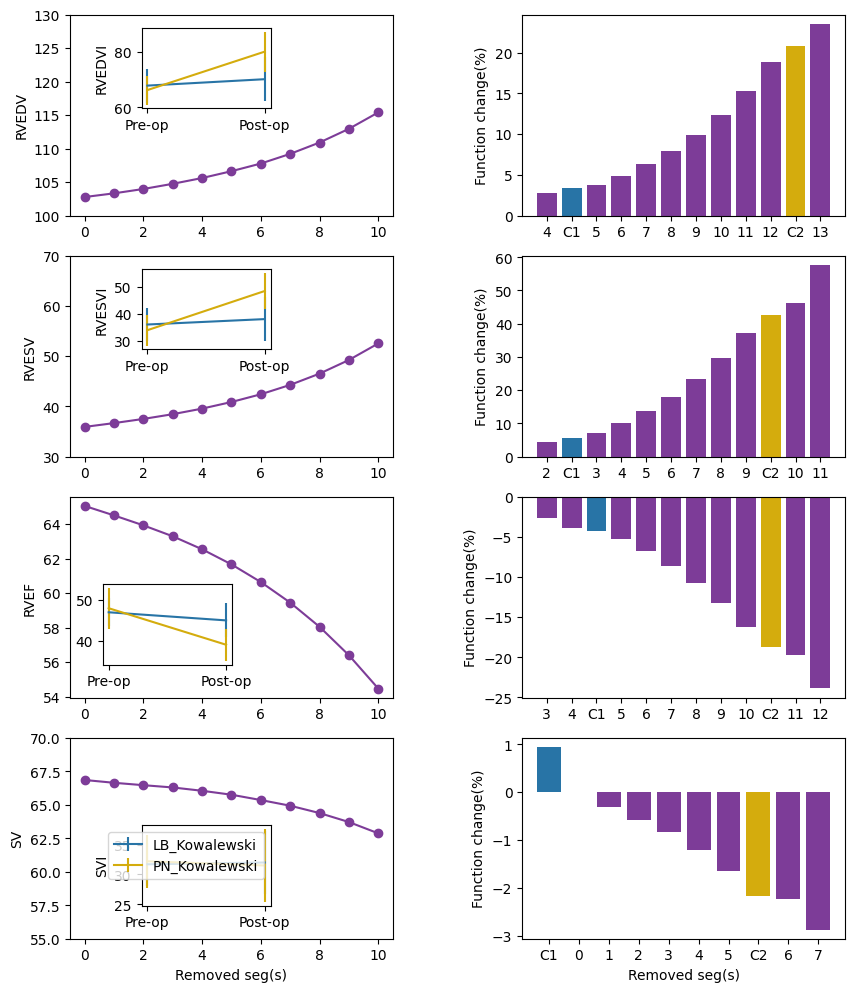

In [291]:
# Kowalewski
fig, axs = plt.subplots(4, 2, figsize=(10, 12)) 
####RVEDVI
rvedvi_cl_pn = [66.2, 80]
rvedvi_err_pn = [5.2, 7.2]
rvedvi_cl_lb = [67.8, 70.1]
rvedvi_err_lb = [6.1, 7.8]

axs[0,0].plot(rm[0:11], rvedv[0:11], marker='o', linestyle='-', color=original, label='RVEDV')
axs[0,0].set_ylabel('RVEDV')
axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.2, 0.5,1, 1), 
                      bbox_transform=axs[0,0].transAxes) 
ax_inset.errorbar(status, rvedvi_cl_lb, yerr = rvedvi_err_lb ,color = L1, label = 'LB_Kowalewski')
ax_inset.errorbar(status, rvedvi_cl_pn, yerr = rvedvi_err_pn ,color = L2, label = 'PN_Kowalewski')
ax_inset.set_ylabel('RVEDVI')
err_rvedv = err_cal(rvedv)
err_rvedvist_lb = err_cal(rvedvi_cl_lb)
err_rvedvist_pn = err_cal(rvedvi_cl_pn)
bar_fig(axs[0,1], err_rvedv, err_rvedvist_lb[-1], err_rvedvist_pn[-1])

rvesvi_cl_pn = [34, 48.5]
rvesvi_err_pn = [5.7, 6.8]
rvesvi_cl_lb = [36.1, 38.1]
rvesvi_err_lb = [6.2, 8.2]

axs[1,0].plot(rm[0:11], rvesv[0:11], marker='o', linestyle='-', color=original, label='RVESV')
axs[1,0].set_ylabel('RVESV')
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[1,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.2, 0.5,1, 1), 
                      bbox_transform=axs[1,0].transAxes) 
ax_inset.errorbar(status, rvesvi_cl_lb, yerr = rvesvi_err_lb ,color = L1, label = 'LB_Kowalewski')
ax_inset.errorbar(status, rvesvi_cl_pn, yerr = rvesvi_err_pn ,color = L2, label = 'PN_Kowalewski')
ax_inset.set_ylabel('RVESVI')
err_rvesv = err_cal(rvesv)
err_rvesvist_lb = err_cal(rvesvi_cl_lb)
err_rvesvist_pn = err_cal(rvesvi_cl_pn)
bar_fig(axs[1,1], err_rvesv, err_rvesvist_lb[-1], err_rvesvist_pn[-1])

rvef_cl_pn = [48, 39]
rvef_err_pn = [5, 4]
rvef_cl_lb = [47, 45]
rvef_err_lb = [3.4, 4.2]

axs[2,0].plot(rm[0:11], rvef[0:11]*100, marker='o', linestyle='-', color=original, label='RVEF')
axs[2,0].set_ylabel('RVEF')
axs[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[2,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.13,1, 1), 
                      bbox_transform=axs[2,0].transAxes) 
ax_inset.errorbar(status, rvef_cl_lb, yerr = rvef_err_lb ,color = L1, label = 'LB_Kowalewski')
ax_inset.errorbar(status, rvef_cl_pn, yerr = rvef_err_pn ,color = L2, label = 'PN_Kowalewski')
err_rvef = err_cal(rvef)
err_rvefst_lb = err_cal(rvef_cl_lb)
err_rvefst_pn = err_cal(rvef_cl_pn)
bar_fig(axs[2,1], err_rvef, err_rvefst_lb[-1], err_rvefst_pn[-1])

rvsv_cl_pn = [32.2, 31.5]
rvsv_err_pn = [4.4, 6.1]
rvsv_cl_lb = [31.7, 32]
rvsv_err_lb = [3.6, 5.3]

axs[3,0].plot(rm[0:11], sv_rv[0:11], marker='o', linestyle='-', color=original, label='SV')
axs[3,0].set_ylabel('SV')
axs[3,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[3,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.2, 0.13,1, 1), 
                      bbox_transform=axs[3,0].transAxes) 
ax_inset.errorbar(status, rvsv_cl_lb, yerr = rvsv_err_lb ,color = L1, label = 'LB_Kowalewski')
ax_inset.errorbar(status, rvsv_cl_pn, yerr = rvsv_err_pn ,color = L2, label = 'PN_Kowalewski')
ax_inset.set_ylabel('SVI')
err_rvsv = err_cal(sv_rv)
err_rvsvst_lb = err_cal(rvsv_cl_lb)
err_rvsvst_pn = err_cal(rvsv_cl_pn)
bar_fig(axs[3,1], err_rvsv, err_rvsvst_lb[-1], err_rvsvst_pn[-1])
plt.subplots_adjust(wspace=0.4)
ax_inset.legend()
axs[0,1].set_ylabel('Function change(%)')
axs[1,1].set_ylabel('Function change(%)')
axs[2,1].set_ylabel('Function change(%)')
axs[3,1].set_ylabel('Function change(%)')
axs[3,0].set_xlabel('Removed seg(s)')
axs[3,1].set_xlabel('Removed seg(s)')
axs[0,0].set_ylim(100,130)
axs[1,0].set_ylim(30,70)
axs[3,0].set_ylim(55,70)
plt.savefig('RV_compare.svg', format='svg')
plt.show()

## LVEF

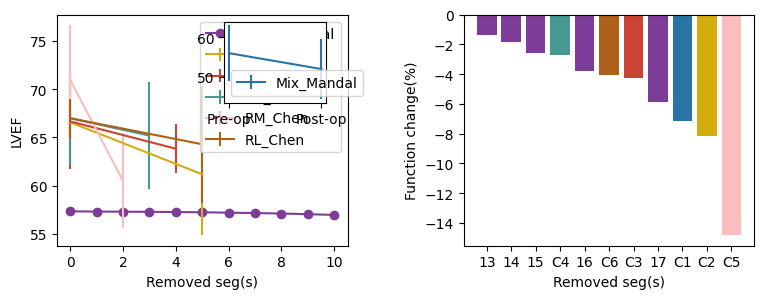

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3)) 
lvef_mandal_mix = [56, 52]
lvef_err_mandal_mix = [7, 7.5]
lvef_chen_lu = [66.58, 61.17]
lvef_chen_err_lu = [4.12, 6.33]

lvef_chen_ll = [66.67, 63.83]
lvef_chen_err_ll = [4.93, 2.56]

lvef_chen_ru = [67, 65.19]
lvef_chen_err_ru = [4.87, 5.54]

lvef_chen_rm = [71, 60.5]
lvef_chen_err_rm = [5.66, 4.95]

lvef_chen_rl = [67, 64.29]
lvef_chen_err_rl = [2.02, 6.08]

axs[0].plot(rm[0:11], lvef[0:11]*100, marker='o', linestyle='-', color=original, label='LVEF_Mandal')
axs[0].errorbar([0,5], lvef_chen_lu, yerr = lvef_chen_err_lu, color = L2, label = 'LU_Chen')
axs[0].errorbar([0,4], lvef_chen_ll, yerr = lvef_chen_err_ll, color = L3, label = 'LL_Chen')
axs[0].errorbar([0,3], lvef_chen_ru, yerr = lvef_chen_err_ru, color = L4, label = 'RU_Chen')
axs[0].errorbar([0,2], lvef_chen_rm, yerr = lvef_chen_err_rm, color = L5, label = 'RM_Chen')
axs[0].errorbar([0,5], lvef_chen_rl, yerr = lvef_chen_err_rl, color = L6, label = 'RL_Chen')
axs[0].set_ylabel('LVEF')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0], width="35%", height="35%", loc="upper right", bbox_to_anchor=(-0.05, 0,1, 1), 
                      bbox_transform=axs[0].transAxes) 
ax_inset.errorbar(status, lvef_mandal_mix , yerr = lvef_err_mandal_mix  ,color = L1, label = 'Mix_Mandal')
err_lvef = err_cal(lvef)
err_lvef_mandal_mix = err_cal(lvef_mandal_mix)
err_lvef_chen_lu = err_cal(lvef_chen_lu)
err_lvef_chen_ll = err_cal(lvef_chen_ll)
err_lvef_chen_ru = err_cal(lvef_chen_ru)
err_lvef_chen_rm = err_cal(lvef_chen_rm)
err_lvef_chen_rl = err_cal(lvef_chen_rl)
bar_fig(axs[1], err_lvef, err_lvef_mandal_mix[-1], err_lvef_chen_lu[-1], err_lvef_chen_ll[-1], err_lvef_chen_ru[-1], err_lvef_chen_rm[-1], err_lvef_chen_rl[-1])
plt.subplots_adjust(wspace=0.4)
ax_inset.legend()
axs[0].legend()
axs[1].set_ylabel('Function change(%)')
axs[0].set_xlabel('Removed seg(s)')
axs[1].set_xlabel('Removed seg(s)')
plt.savefig('LVEF_compare.svg', format='svg')
